In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from tqdm.std import trange
import math

In [2]:
df_state = pd.read_excel('./state.xlsx')
df_car_datasets = pd.read_csv('./USA_cars_datasets.csv')

In [3]:
# Make the state case lower
df_state.loc[:, 'State or territory'] = df_state.loc[:, 'State or territory'].map(lambda x: str(x).lower().replace('\xa0', ''))
df_state.loc[:, 'State or territory'] = df_state.loc[:, 'State or territory'].map(lambda x: 'washington' if x == 'washington, d.c.' else x)

# Delete unexpected data
df_car_datasets = df_car_datasets.dropna()
df_car_datasets = df_car_datasets.drop(df_car_datasets[df_car_datasets['mileage'] < 1000].index)
df_car_datasets = df_car_datasets.drop(df_car_datasets[df_car_datasets['price'] < 1000].index)
df_car_datasets = df_car_datasets.drop(df_car_datasets[df_car_datasets['year'] < 2010].index)

# Clear some unexpected columns and rows caused by the Excel sheet.
df_car_datasets = df_car_datasets.drop(axis=1, columns=['Unnamed: 0'])
df_state = df_state.drop(axis=0, index=[0, 1, 2])
df_state = df_state.reset_index().drop(axis=1, columns=['index']).dropna()

# Transform "$10,000" to "10000"
transform_columns = ['Per capita', 'Personal per capita income (2020), BEA[10]', 'Of which disposable personal per capita income (2020), BEA[11]', 'Median', 'Median.1']
for col in transform_columns:
    df_state.loc[:, col] = df_state.loc[:, col].map(lambda x: float(str(x).replace("$", '').replace(",", '')))

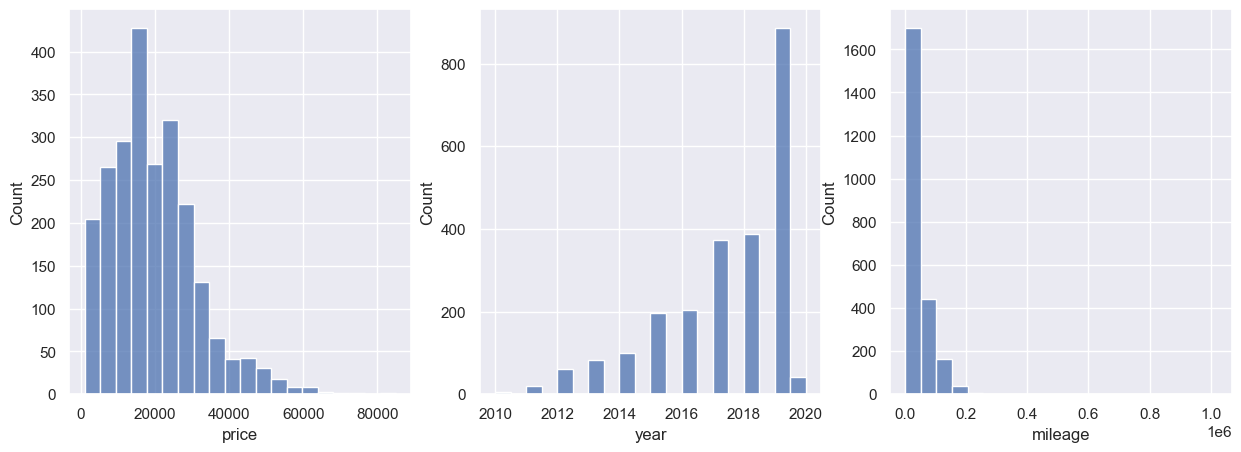

In [4]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=df_car_datasets, x="price", bins=20, ax=axs[0])
sns.histplot(data=df_car_datasets, x="year", bins=20, ax=axs[1])
sns.histplot(data=df_car_datasets, x="mileage", bins=20, ax=axs[2])

plt.show()

The critical 3 datas look not normal distributed, we will make some transformation.

In [5]:
# Make the data looks normal
df_car_datasets.loc[:, 'log_price'] = np.log(df_car_datasets.loc[:, 'price'])
df_car_datasets.loc[:, 'log_mileage'] = np.log(df_car_datasets.loc[:, 'mileage'])
df_car_datasets.loc[:, 'year2'] = (df_car_datasets.loc[:, 'year'] - 2010) ** 2

# Add column transformed from text.
df_car_datasets.loc[:, 'brand_model'] = df_car_datasets.loc[:, 'brand'] + '-' + df_car_datasets.loc[:, 'model']
df_car_datasets.loc[:, 'title_status_clean'] = df_car_datasets.loc[:, 'title_status'].map(lambda x: 1 if x == 'clean vehicle' else 0)

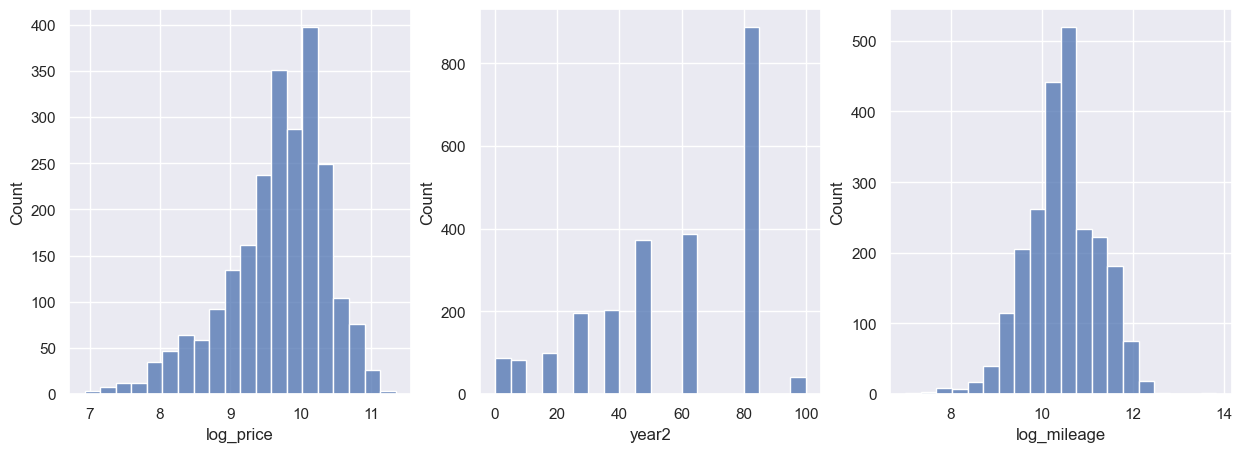

In [6]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=df_car_datasets, x="log_price", bins=20, ax=axs[0])
sns.histplot(data=df_car_datasets, x="year2", bins=20, ax=axs[1])
sns.histplot(data=df_car_datasets, x="log_mileage", bins=20, ax=axs[2])

plt.show()

In [7]:
# Normalize
df_car_datasets.loc[:, 'year2_'] = (df_car_datasets['year2'] - df_car_datasets['year2'].mean()) / df_car_datasets['year2'].std()
df_car_datasets.loc[:, 'log_mileage_'] = (df_car_datasets['log_mileage'] - df_car_datasets['log_mileage'].mean()) / df_car_datasets['log_mileage'].std()
df_car_datasets.loc[:, 'title_status_clean_'] = (df_car_datasets['title_status_clean'] - df_car_datasets['title_status_clean'].mean()) / df_car_datasets['title_status_clean'].std()

### Problem 1 :

In [8]:
df_state.rename(columns={'State or territory':'state'}, inplace=True)
df_state_gdp = df_state.groupby(by=['state']).mean().reset_index()
df_state_gdp.head(5)

,state,Per capita,"Personal per capita income (2020), BEA[10]","Of which disposable personal per capita income (2020), BEA[11]",Median,Median.1,"Population (April 1, 2020)"
0,alabama,28650.0,46479.0,42392.0,51734.0,66171.0,5024279.0
1,alaska,36978.0,63502.0,59053.0,75463.0,91971.0,733391.0
2,arizona,32173.0,49648.0,45025.0,62055.0,74468.0,7151502.0
3,arkansas,27274.0,47235.0,43083.0,48952.0,62387.0,3011524.0
4,california,39393.0,70192.0,60796.0,80440.0,91377.0,39538223.0


In [9]:
df_car_state = df_car_datasets.groupby(by=['state']).mean().reset_index()
df_car_state.head(5)

,state,price,year,mileage,lot,log_price,log_mileage,year2,title_status_clean,year2_,log_mileage_,title_status_clean_
0,alabama,23872.058824,2016.352941,64916.176471,1.677416e+08,9.779967,10.912924,43.882353,1.000000,-0.506724,0.584226,0.177511
1,arizona,15926.666667,2017.833333,31805.100000,1.675652e+08,9.526146,10.052841,65.500000,1.000000,0.341356,-0.515912,0.177511
2,arkansas,7435.000000,2014.166667,72893.166667,1.676102e+08,8.680840,11.109932,23.500000,0.500000,-1.306343,0.836221,-2.726771
3,california,18583.333333,2017.616667,40240.483333,1.676697e+08,9.619421,10.420709,60.616667,0.972222,0.149778,-0.045370,0.016162
4,colorado,18992.857143,2016.500000,50236.000000,1.676291e+08,9.776871,10.526250,46.642857,1.000000,-0.398427,0.089629,0.177511


In [10]:
df_all = pd.merge(df_car_state, df_state_gdp)
df_all["s_price"] = (df_all["price"] - np.mean(df_all["price"])) / np.std(df_all["price"])
df_all["s_Personal per capita income"] = (df_all["Personal per capita income (2020), BEA[10]"] - np.mean(df_all["Personal per capita income (2020), BEA[10]"])) / np.std(df_all["Personal per capita income (2020), BEA[10]"])
df_all.head(5)

,state,price,year,mileage,lot,log_price,log_mileage,year2,title_status_clean,year2_,log_mileage_,title_status_clean_,Per capita,"Personal per capita income (2020), BEA[10]","Of which disposable personal per capita income (2020), BEA[11]",Median,Median.1,"Population (April 1, 2020)",s_price,s_Personal per capita income
0,alabama,23872.058824,2016.352941,64916.176471,1.677416e+08,9.779967,10.912924,43.882353,1.000000,-0.506724,0.584226,0.177511,28650.0,46479.0,42392.0,51734.0,66171.0,5024279.0,0.648215,-1.126448
1,arizona,15926.666667,2017.833333,31805.100000,1.675652e+08,9.526146,10.052841,65.500000,1.000000,0.341356,-0.515912,0.177511,32173.0,49648.0,45025.0,62055.0,74468.0,7151502.0,-0.344606,-0.791194
2,arkansas,7435.000000,2014.166667,72893.166667,1.676102e+08,8.680840,11.109932,23.500000,0.500000,-1.306343,0.836221,-2.726771,27274.0,47235.0,43083.0,48952.0,62387.0,3011524.0,-1.405688,-1.046470
3,california,18583.333333,2017.616667,40240.483333,1.676697e+08,9.619421,10.420709,60.616667,0.972222,0.149778,-0.045370,0.016162,39393.0,70192.0,60796.0,80440.0,91377.0,39538223.0,-0.012641,1.382189
4,colorado,18992.857143,2016.500000,50236.000000,1.676291e+08,9.776871,10.526250,46.642857,1.000000,-0.398427,0.089629,0.177511,41053.0,63776.0,56415.0,77127.0,95164.0,5773714.0,0.038531,0.703430


In [11]:
df_all.loc[:,["state", "s_price","s_Personal per capita income"]].head(5)

,state,s_price,s_Personal per capita income
0,alabama,0.648215,-1.126448
1,arizona,-0.344606,-0.791194
2,arkansas,-1.405688,-1.046470
3,california,-0.012641,1.382189
4,colorado,0.038531,0.703430


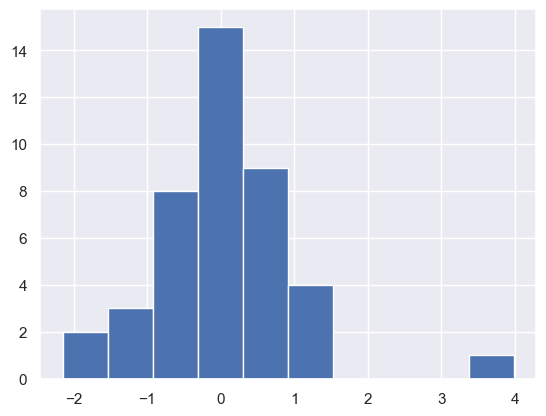

In [12]:
plt.hist(df_all["s_price"])
plt.show()

Text(0, 0.5, 'Personal per capita income')

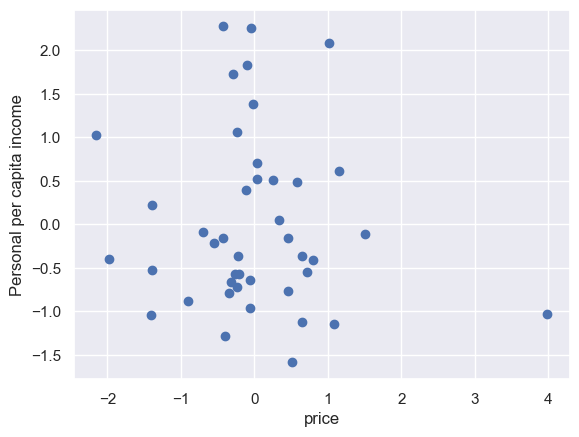

In [13]:
X1 = df_all.loc[:, ["s_price"]]
y1 = df_all.loc[:, ["s_Personal per capita income"]]
plt.scatter(X1, y1)
plt.xlabel("price")
plt.ylabel("Personal per capita income")

In [14]:
X2 = df_all["s_price"]
X2 = sm.add_constant(X2)
y2 = df_all["s_Personal per capita income"]
ols_ppc = sm.OLS(y2, X2)
model_ppc = ols_ppc.fit()
model_ppc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     s_Personal per capita income   R-squared:                       0.010
Model:                                      OLS   Adj. R-squared:                 -0.015
Method:                           Least Squares   F-statistic:                    0.3899
Date:                          Wed, 14 Dec 2022   Prob (F-statistic):              0.536
Time:                                  11:31:16   Log-Likelihood:                -59.392
No. Observations:                            42   AIC:                             122.8
Df Residuals:                                40   BIC:                             126.3
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.576e-17      0.157   6.09e-16      1.000      -0.318       0.318
s_price       -0.0983      0.157     -0.624      0.536      -0.416       0.220
==============================================================================
Omnibus:                        5.184   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                4.875
Skew:                           0.829   Prob(JB):                       0.0874
Kurtosis:                       2.811   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### R-squared:	0.010

#### H0: β1 = 0
#### H1: β1 ≠ 0

In [15]:
from scipy.stats import f
var1 = np.var(df_all["s_price"])
var2 = np.var(df_all["s_Personal per capita income"])
F = var1 / var2
df1 = len(df_all["s_price"]) - 1
df2 = len(df_all["s_Personal per capita income"]) - 1
P_value = 1 - 2 * abs(0.5 - f.cdf(F, df1, df2))
print(P_value)

0.9999999999999993


#### p-value: 1.0 > 0.05

In [16]:
from scipy.stats import ttest_1samp
from scipy import stats
print(stats.ttest_ind(X1,y1))

Ttest_indResult(statistic=array([-4.84722181e-16]), pvalue=array([1.]))


#### p-value: 1.0 > 0.05
#### Accept H0: There is no significance between state average used car prices and state personal per capita income

### Problem 2 :

In [17]:
df_p1 = df_car_datasets.loc[:, ('price', 'log_price', 'mileage', 'log_mileage', 'year', 'title_status_clean')]

In [18]:
df_p1.describe()

,price,log_price,mileage,log_mileage,year,title_status_clean
count,2356.000000,2356.000000,2.356000e+03,2356.000000,2356.000000,2356.00000
mean,19600.726231,9.677337,4.692227e+04,10.456179,2017.252971,0.96944
std,11640.568439,0.704109,4.681705e+04,0.781795,2.048170,0.17216
min,1025.000000,6.932448,1.091000e+03,6.994850,2010.000000,0.00000
25%,11100.000000,9.314700,2.128100e+04,9.965570,2016.000000,1.00000
50%,17500.000000,9.769956,3.468550e+04,10.454077,2018.000000,1.00000
75%,26000.000000,10.165852,5.701725e+04,10.951109,2019.000000,1.00000
max,84900.000000,11.349229,1.017936e+06,13.833288,2020.000000,1.00000


In [19]:
for color in ['white', 'blue', 'red', 'gray', 'silver', 'red']:
    df_p1['color_' + color] = df_car_datasets[['color']][df_car_datasets['color'] == color].replace({color: 1})
    df_p1['color_' + color] = df_p1['color_' + color].fillna(0)
df_p1

,price,log_price,mileage,log_mileage,year,title_status_clean,color_white,color_blue,color_red,color_gray,color_silver
1,2899,7.972121,190552.0,12.157680,2011,1,0.0,0.0,0.0,0.0,1.0
2,5350,8.584852,39590.0,10.586332,2018,1,0.0,0.0,0.0,0.0,1.0
3,25000,10.126631,64146.0,11.068917,2014,1,0.0,1.0,0.0,0.0,0.0
4,27700,10.229188,6654.0,8.802973,2018,1,0.0,0.0,1.0,0.0,0.0
5,5700,8.648221,45561.0,10.726807,2018,1,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2494,7800,8.961879,23609.0,10.069383,2019,1,0.0,0.0,1.0,0.0,0.0
2495,9200,9.126959,34553.0,10.450250,2018,1,0.0,0.0,0.0,0.0,1.0
2496,9200,9.126959,31594.0,10.360723,2018,1,0.0,0.0,0.0,0.0,1.0
2497,9200,9.126959,32557.0,10.390748,2018,1,0.0,0.0,0.0,0.0,0.0


In [20]:
predictors = ('log_mileage', 'year', 'title_status_clean', 'color_white', 'color_blue', 'color_red', 'color_gray', 'color_silver')
y = df_p1.loc[:, 'log_price']
X = df_p1.loc[:, predictors]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     168.6
Date:                Wed, 14 Dec 2022   Prob (F-statistic):          5.60e-225
Time:                        11:31:16   Log-Likelihood:                -1981.2
No. Observations:                2356   AIC:                             3980.
Df Residuals:                    2347   BIC:                             4032.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -126.1008     15.821     -7.970      0.000    -157.126     -95.075
log_mileage           -0.2922      0.020    -14.521      0.000      -0.332      -0.253
year                   0.0684      0.008      8.785      0.000       0.053       0.084
title_status_clean     1.0337      0.070     14.760      0.000       0.896       1.171
color_white            0.0185      0.030      0.608      0.543      -0.041       0.078
color_blue            -0.1558      0.052     -2.994      0.003      -0.258      -0.054
color_red             -0.0711      0.047     -1.498      0.134      -0.164       0.022
color_gray            -0.1763      0.036     -4.887      0.000      -0.247      -0.106
color_silver          -0.1549      0.040     -3.907      0.000      -0.233      -0.077
==============================================================================
Omnibus:                       60.074   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.445
Skew:                          -0.356   Prob(JB):                     2.26e-15
Kurtosis:                       3.424   Cond. No.                     2.76e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.76e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### R2 = 0.365

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [22]:
vif = pd.DataFrame()
vif['variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,variable,VIF
0,const,1.866704e+06
1,log_mileage,1.844541e+00
2,year,1.893001e+00
3,title_status_clean,1.083712e+00
4,color_white,1.409224e+00
5,color_blue,1.128311e+00
6,color_red,1.161095e+00
7,color_gray,1.296634e+00
8,color_silver,1.252921e+00


#### As R2 is only 0.365, we think the model is not fitted well. 
#### We can easily know that, the car brand will affect a lot on price. As a result, we only choose 2 models -- `Ford` and `Chevrolet`.

### Problem 3 :

In [23]:
brand_filter = ('ford', 'chevrolet')

df_p2 = df_car_datasets.query('`brand` in @brand_filter').copy().loc[:, ('log_price', 'brand', 'mileage', 'log_mileage', 'year', 'year2', 'title_status_clean', 
                                                                    'year2_', 'log_mileage_', 'title_status_clean_', 'state')]

In [24]:
df_p2

,log_price,brand,mileage,log_mileage,year,year2,title_status_clean,year2_,log_mileage_,title_status_clean_,state
1,7.972121,ford,190552.0,12.157680,2011,1,1,-2.189038,2.176404,0.177511,tennessee
3,10.126631,ford,64146.0,11.068917,2014,16,1,-1.600574,0.783758,0.177511,virginia
4,10.229188,chevrolet,6654.0,8.802973,2018,64,1,0.282509,-2.114627,0.177511,florida
6,8.895630,chevrolet,149050.0,11.912037,2010,0,1,-2.228269,1.862200,0.177511,georgia
8,9.588777,chevrolet,9371.0,9.145375,2018,64,1,0.282509,-1.676659,0.177511,florida
...,...,...,...,...,...,...,...,...,...,...,...
2199,9.532424,ford,29345.0,10.286877,2019,81,1,0.949435,-0.216554,0.177511,north carolina
2200,10.933107,ford,25371.0,10.141362,2018,64,1,0.282509,-0.402684,0.177511,pennsylvania
2201,9.532424,ford,30054.0,10.310751,2019,81,1,0.949435,-0.186017,0.177511,north carolina
2202,10.732039,ford,11173.0,9.321255,2018,64,1,0.282509,-1.451689,0.177511,pennsylvania


In [25]:
df_state_0 = pd.DataFrame(df_state.loc[:, ('state', 'Personal per capita income (2020), BEA[10]')]).rename(columns={'State or territory': 'state', 'Personal per capita income (2020), BEA[10]': 'gdp'})

In [26]:
df_p2.loc[:, 'brand_ford'] = df_p2.loc[:, 'brand'].replace({'ford': 1, 'chevrolet': 0})
df_p2 = df_p2.merge(df_state_0, how='inner', on='state')
for color in ['white', 'blue', 'red', 'gray', 'silver', 'red']:
    df_p2['color_' + color] = df_car_datasets[['color']][df_car_datasets['color'] == color].replace({color: 1})
    df_p2['color_' + color] = df_p2['color_' + color].fillna(0)
df_p2.loc[:, 'gdp_'] = (df_p2['gdp'] - df_p2['gdp'].mean()) / df_p2['gdp'].std()
df_p2

,log_price,brand,mileage,log_mileage,year,year2,title_status_clean,year2_,log_mileage_,title_status_clean_,state,brand_ford,gdp,color_white,color_blue,color_red,color_gray,color_silver,gdp_
0,7.972121,ford,190552.0,12.157680,2011,1,1,-2.189038,2.176404,0.177511,tennessee,1,51046.0,0.0,0.0,0.0,0.0,0.0,-0.890839
1,10.370361,chevrolet,22909.0,10.039285,2018,64,1,0.282509,-0.533251,0.177511,tennessee,0,51046.0,0.0,0.0,0.0,0.0,1.0,-0.890839
2,9.862666,chevrolet,2430.0,7.795647,2018,64,1,0.282509,-3.403106,0.177511,tennessee,0,51046.0,0.0,0.0,0.0,0.0,1.0,-0.890839
3,10.325482,chevrolet,30442.0,10.323579,2018,64,1,0.282509,-0.169610,0.177511,tennessee,0,51046.0,0.0,1.0,0.0,0.0,0.0,-0.890839
4,9.852194,chevrolet,18414.0,9.820867,2017,49,1,-0.305954,-0.812632,0.177511,tennessee,0,51046.0,0.0,0.0,1.0,0.0,0.0,-0.890839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,9.433484,ford,100947.0,11.522351,2016,36,0,-0.815956,1.363749,-5.631053,idaho,1,48759.0,0.0,0.0,0.0,0.0,0.0,-1.168791
1446,9.949894,ford,40793.0,10.616266,2018,64,1,0.282509,0.204769,0.177511,new hampshire,1,67097.0,0.0,1.0,0.0,0.0,0.0,1.059930
1447,10.165659,ford,39509.0,10.584284,2015,25,1,-1.247496,0.163860,0.177511,new hampshire,1,67097.0,0.0,0.0,0.0,0.0,0.0,1.059930
1448,7.946264,ford,363810.0,12.804387,2014,16,0,-1.600574,3.003611,-5.631053,montana,1,53361.0,0.0,0.0,1.0,0.0,0.0,-0.609484


In [27]:
predictors = ['log_mileage_', 'year2_', 'title_status_clean_', 'brand_ford', 'gdp_']
result = 'log_price'
y = df_p2.loc[:, result]
X = df_p2.loc[:, predictors]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X1_train = sm.add_constant(X_train)
lm = sm.OLS(y_train, X1_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     146.2
Date:                Wed, 14 Dec 2022   Prob (F-statistic):          2.85e-120
Time:                        11:31:16   Log-Likelihood:                -930.56
No. Observations:                1160   AIC:                             1873.
Df Residuals:                    1154   BIC:                             1903.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   9.8210      0.037    265.897      0.000       9.749       9.893
log_mileage_           -0.1501      0.021     -7.029      0.000      -0.192      -0.108
year2_                  0.2185      0.023      9.643      0.000       0.174       0.263
title_status_clean_     0.1714      0.017     10.103      0.000       0.138       0.205
brand_ford              0.0049      0.041      0.121      0.904      -0.075       0.085
gdp_                    0.0565      0.016      3.454      0.001       0.024       0.089
==============================================================================
Omnibus:                       22.497   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.288
Skew:                          -0.341   Prob(JB):                     8.77e-06
Kurtosis:                       3.130   Cond. No.                         4.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
predictors = ['log_mileage_', 'year2_', 'title_status_clean_', 'brand_ford', 'gdp_', 'color_white', 'color_blue', 'color_red', 'color_gray', 'color_silver']
result = 'log_price'
y = df_p2.loc[:, result]
X = df_p2.loc[:, predictors]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X1_train = sm.add_constant(X_train)
lm = sm.OLS(y_train, X1_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     73.28
Date:                Wed, 14 Dec 2022   Prob (F-statistic):          8.76e-116
Time:                        11:31:16   Log-Likelihood:                -929.00
No. Observations:                1160   AIC:                             1880.
Df Residuals:                    1149   BIC:                             1936.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   9.8363      0.044    222.023      0.000       9.749       9.923
log_mileage_           -0.1500      0.021     -6.999      0.000      -0.192      -0.108
year2_                  0.2192      0.023      9.652      0.000       0.175       0.264
title_status_clean_     0.1698      0.017      9.968      0.000       0.136       0.203
brand_ford              0.0015      0.041      0.037      0.970      -0.079       0.082
gdp_                    0.0571      0.016      3.469      0.001       0.025       0.089
color_white             0.0064      0.041      0.157      0.876      -0.073       0.086
color_blue              0.0020      0.081      0.025      0.980      -0.157       0.161
color_red              -0.0211      0.063     -0.336      0.737      -0.144       0.102
color_gray             -0.0784      0.050     -1.556      0.120      -0.177       0.020
color_silver           -0.0135      0.055     -0.244      0.807      -0.122       0.095
==============================================================================
Omnibus:                       23.410   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.301
Skew:                          -0.350   Prob(JB):                     5.28e-06
Kurtosis:                       3.119   Cond. No.                         7.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
mean_squared_error(y_test, y_test_pred)

0.32293088198717884

We use Ridge model:

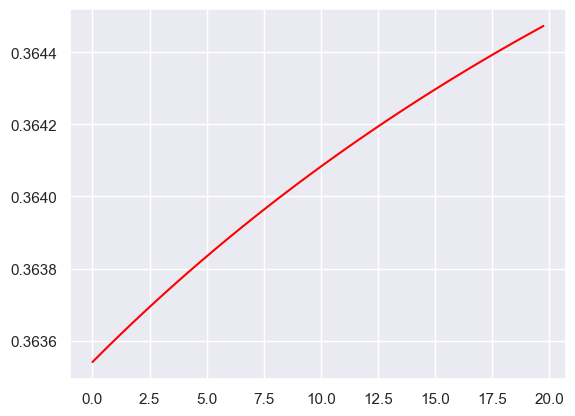

In [30]:
from sklearn.linear_model import Ridge
cv_score = []
for alpha in np.arange(0.0, 20.0, 0.25):
    reg = Ridge(alpha=alpha)
    val_score = cross_val_score(reg, X_train, y=y_train, cv=10)
    cv_score.append(np.mean(val_score))
sns.lineplot(x=np.arange(0.0, 20.0, 0.25), y=cv_score, color='red')
plt.show()

In [31]:
reg = Ridge(alpha=1.0)
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
mean_squared_error(y_test, y_test_pred)

0.32291189414618

We use decision tree regression:

In [32]:
from sklearn.tree import DecisionTreeRegressor

In [33]:
reg = DecisionTreeRegressor(random_state=514)
reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=514)

In [34]:
y_test_pred = reg.predict(X_test)
mean_squared_error(y_test, y_test_pred)

0.52858089094329

Bagging may be better?

100%|███████████████████████████████████████████| 20/20 [01:05<00:00,  3.28s/it]


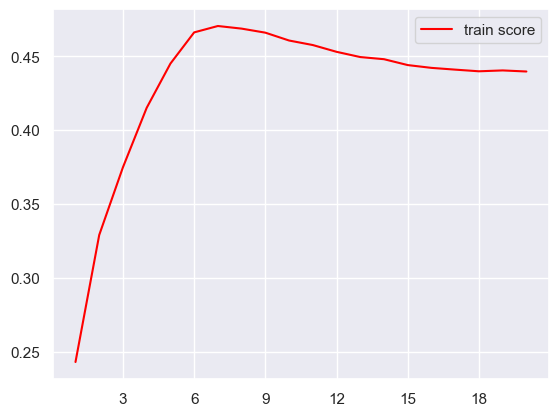

In [35]:
# Bagging

from sklearn.ensemble import RandomForestRegressor
from matplotlib.ticker import MaxNLocator

cv_score = []

for depth in trange(1, 21):
    reg2 = RandomForestRegressor(n_estimators=300, random_state=514, max_depth=depth)
    val_score = cross_val_score(reg2, X_train, y=y_train, cv=10)
    cv_score.append(np.mean(val_score))
    
sns.lineplot(x=np.arange(1, 21), y=cv_score, color='red')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(['train score'])
plt.show()

depth = 7 or 8 is ok.

In [36]:
reg = RandomForestRegressor(n_estimators=300, random_state=514, max_depth=7)
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
mean_squared_error(y_test, y_test_pred)

0.2783726122936817